In [1]:
import numpy as np
from matplotlib import pyplot as plt
from ase import units
import glob
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/apdft-ofdft-cpmd/')
import profess_io as pio
import analyse_MD as aMD

In [2]:
def sort_dat_files(list_of_files):
    sorted_index = []
    for i in list_of_files:
        sorted_index.append((float(i.split('.')[-2]), i))
    sorted_index.sort(key=lambda tup: tup[0])  # sorts in place
    data_sorted = []
    for item in sorted_index:
        data_sorted.append(item[1])
    return(data_sorted)

def plot_energy(time, energy, energy_label):
    plt.rcParams['font.size'] = 16
    fig, ax = plt.subplots(1,1)
    ax.plot(time[0][:500], energy[0][:500], label=r'dt=0.1, tol = $10^{-5}$')
    ax.plot(time[1],energy[1], label='dt=0.01, tol = $10^{-5}$')
    ax.plot(time[2], energy[2], label='dt=0.001, tol = $10^{-5}$')
#     ax.plot(time[3], energy[3], label='dt=0.1, tol = $10^{-6}$')
#     ax.plot(time[4], energy[4], label='dt=0.1, tol = $10^{-8}$')
#     ax.plot(time[5][:1000], energy[5][:1000], label='restarted dt=0.1, tol = $10^{-8}$')
#     ax.plot(time[6], energy[6], label='dt=0.1, tol = $10^{-10}$')
#     ax.plot(time[7], energy[7], label='dt=0.1, tol = $10^{-12}$')
#     ax.plot(time[8], energy[8], label='dt=0.01, tol = $10^{-6}$')
    # ax.plot(time[3][:500], etot[3][:500], label='restart')

    ax.set_xlabel('t (fs)')
    ax.set_ylabel(energy_label)

    # for t, v, l in zip(time, epot, labels):
    #     ax.plot(t,v, label = l)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    return(fig, ax)

def drift(time, energy, num_atom, tstart=None, tend=None):
    """
    in: time in fs, energy in Ha
    out: drift in Ha/(atom*ps)
    
    """
    
    
    if tstart == None and tend == None:
        dE = (energy[-1]-energy[0])/(time[-1]-time[0])
        dE = dE/num_atom*1000 # conversion from eV/fs to Ha/atom/ps
    else:
        dE = (energy[tend]-energy[tstart])/(time[tend] - time[tstart])/num_atom*1000

    return(dE)

def parse_energies(paths, keys=None):
    epot = []
    ekin = []
    etot = []
    for p in paths:
        epot_tmp = np.array(pio.parse_out_file(p, 'NVE Potential energy'))
        ekin_tmp = np.array(pio.parse_out_file(p, 'NVE Kinetic energy'))
        etot_tmp = epot_tmp + ekin_tmp

        epot.append(epot_tmp)
        ekin.append(ekin_tmp)
        etot.append(etot_tmp)
        
    if keys:
        ekin = make_dict(keys, ekin)
        epot = make_dict(keys, epot)
        etot = make_dict(keys, etot)
    return(ekin, epot, etot)

def make_dict(keys, values):
    tmp_dict = dict()
    for k, v in zip(keys, values):
        tmp_dict[k] = v
    return(tmp_dict)

def get_times(dts, lengths, keys=None):
    time = []
    for dt, l in zip(dts, lengths):
        time.append(np.arange(0, l*dt, dt))
    if keys:
        time = make_dict(keys, time)
    return(time)

### Long MD reference

In [3]:
ref = '/home/misa/projects/APDFT-CPMD/data/BOMD/Si8_hc_NVE_ref/nve_Si8.out'
epot_ref = np.array(pio.parse_out_file(ref, 'NVE Potential energy'))*units.Ha
ekin_ref = np.array(pio.parse_out_file(ref, 'NVE Kinetic energy'))*units.Ha
etot_ref = epot_ref + ekin_ref
temp_ref = np.array(pio.parse_out_file(ref, 'nve temperature'))

dt_ref = 0.1
time_ref = np.arange(0, len(epot_ref)*dt_ref, dt_ref)

Text(0, 0.5, 'T (K)')

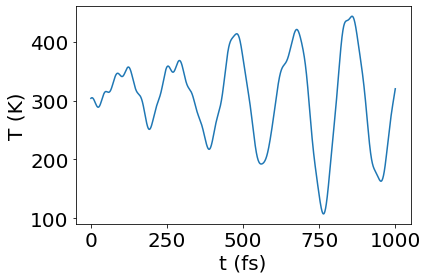

In [4]:
plt.rcParams['font.size'] = 20

plt.plot(time_ref[:10000], temp_ref[:10000])
plt.xlabel('t (fs)')
plt.ylabel('T (K)')

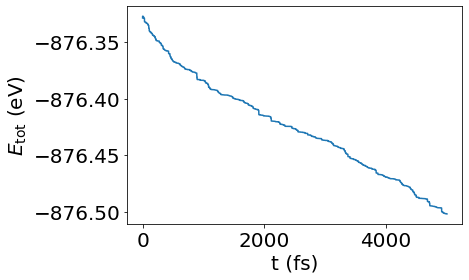

In [5]:
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,1)

ax.plot(time_ref, etot_ref)
ax.set_xlabel('t (fs)')
ax.set_ylabel(r'$E_{\rm tot}$ (eV)')

plt.savefig('/home/misa/projects/APDFT-CPMD/figures/Chuck/etot_vs_time.png',bbox_inches='tight')

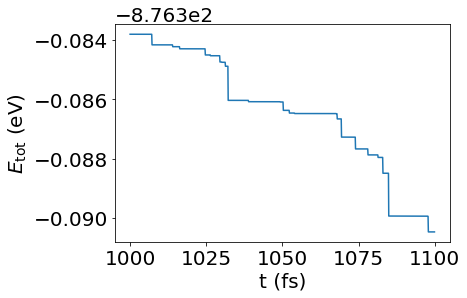

In [6]:
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,1)

ax.plot(time_ref[10000:11000], etot_ref[10000:11000])
ax.set_xlabel('t (fs)')
ax.set_ylabel(r'$E_{\rm tot}$ (eV)')

plt.savefig('/home/misa/projects/APDFT-CPMD/figures/Chuck/etot_vs_time_zoom_in.png',bbox_inches='tight')

In [7]:
drift(time_ref, etot_ref/units.Ha, 8)

-0.0001593137500648175

In [60]:
ion_files = aMD.sort_dat_files(ion_files)
pos_ref = aMD.get_positions2(ion_files)

### CPMD run

In [8]:
data_cpmd = np.loadtxt('/home/misa/projects/APDFT-CPMD/data/CPMD/Si8_dt_1e-3/Si8_dt_1e-3.log', skiprows=1)

In [9]:
time = data_cpmd[:,0]*1000

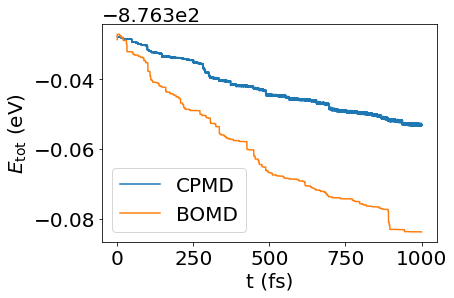

In [128]:
fig,ax = plt.subplots(1,1)

ax.plot(time, data_cpmd[:,1], label='CPMD')

ax.plot(time_ref[:10000], etot_ref[:10000], label='BOMD')
ax.set_xlabel('t (fs)')
ax.set_ylabel(r'$E_{\rm tot}$ (eV)')
ax.legend()
plt.savefig('/home/misa/projects/phd_symposium_2021/figures/CPMD_BOMD_drift_etot.png', bbox_inches='tight')

In [11]:
drift(time, data_cpmd[:,1]/units.Ha,8)

-0.00011595577814116353

Text(0, 0.5, '$E_{\\rm pot}$ (eV)')

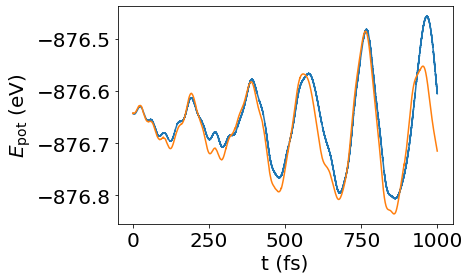

In [13]:
fig,ax = plt.subplots(1,1)

ax.plot(time, data_cpmd[:,2])
ax.plot(time_ref[:10000], epot_ref[:10000])
ax.set_xlabel('t (fs)')
ax.set_ylabel(r'$E_{\rm pot}$ (eV)')

Text(0, 0.5, 'T (K)')

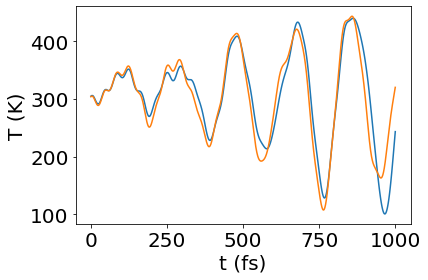

In [21]:
fig,ax = plt.subplots(1,1)

ax.plot(time, data_cpmd[:,4])
plt.plot(time_ref[:10000], temp_ref[:10000])
plt.xlabel('t (fs)')
plt.ylabel('T (K)')

### kinetic energy of electron density

In [16]:
ekin_dens = np.loadtxt('/home/misa/projects/APDFT-CPMD/data/CPMD/Si8_dt_1e-3/ekin_dens.txt')

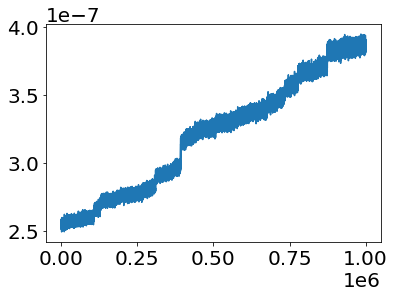

In [35]:
fig,ax = plt.subplots(1,1)
ax.plot(ekin_dens[-1000000:])

In [78]:
from ase.io.trajectory import Trajectory

In [79]:
cpmd_traj = Trajectory('/home/misa/projects/APDFT-CPMD/data/CPMD/Si8_dt_1e-3/Si8_dt_1e-3.traj')
#traj = Trajectory('example.traj')

In [118]:
pos_cpmd = []
for tr in range(0, len(cpmd_traj), 100):
    pos_cpmd.append(cpmd_traj[tr].get_positions())

In [119]:
pos_cpmd = np.array(pos_cpmd)

In [116]:
pos_cpmd[:,0,0]

array([0.94652313, 0.9466461 , 0.9467687 , ..., 0.70006843, 0.69980988,
       0.69955103])

In [101]:
shift = pos_ref[:,0,0][0]-pos_ref[:,0,0][1]

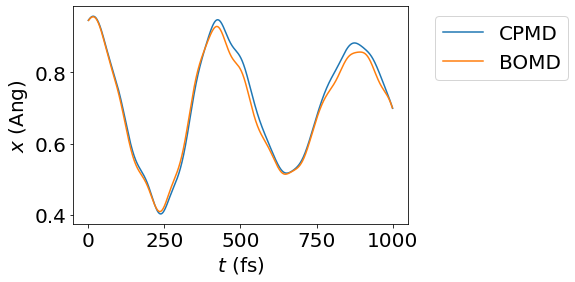

In [129]:
fig,ax = plt.subplots(1,1)

ax.plot(np.linspace(0, 1000, len(pos_cpmd[:,0,0])), pos_cpmd[:,0,0], label = 'CPMD')
ax.plot(np.linspace(0, 5000, len(pos_ref[:,0,0]))[1:1000], pos_ref[:,0,0][1:1000]+shift, label = 'BOMD')

ax.set_xlabel(r'$t$ (fs)')
ax.set_ylabel(r'$x$ (Ang)')
ax.legend(bbox_to_anchor = (1.05,1.0))
plt.savefig('/home/misa/projects/phd_symposium_2021/figures/CPMD_BOMD_traj.png', bbox_inches='tight')

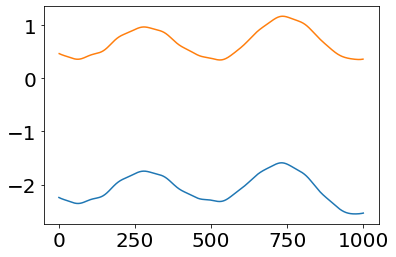

In [121]:
fig,ax = plt.subplots(1,1)

ax.plot(np.linspace(0, 1000, len(pos_cpmd[:,1,0])), pos_cpmd[:,1,0])
ax.plot(np.linspace(0, 5000, len(pos_ref[:,1,0]))[1:1000], pos_ref[:,1,0][1:1000])

In [85]:
n

5001

### Splines

In [ ]:
spline_4 = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_spline_4/nve_Si8.out'
spline_8 = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_spline_8/nve_Si8.out'
spline_20 = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_spline_20/nve_Si8.out'
spline_no = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_spline_no/nve_Si8.out'

In [ ]:
ekin_spline, epot_spline, etot_spline = parse_energies([spline_4, spline_8, spline_20, spline_no])
time_spline = get_times([0.1, 0.1, 0.1, 0.1], [len(etot_spline[0]), len(etot_spline[1]), len(etot_spline[2]), len(etot_spline[3])])

In [ ]:
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,1)

ax.plot(time_spline[0], etot_spline[0], label = 'spline = 4')
ax.plot(time_spline[1], etot_spline[1], label = 'spline = 8')
ax.plot(time_spline[2], etot_spline[2], label = 'spline = 20')
ax.plot(time_spline[3], etot_spline[3], label = 'spline = no')

ax.set_xlabel('t (fs)')
ax.set_ylabel(r'$E_{\rm tot}$ (eV)')
ax.legend()
#plt.savefig('/home/misa/projects/APDFT-CPMD/figures/Chuck/etot_vs_time.png',bbox_inches='tight')

In [ ]:
drift_sp4 = drift(time_spline[0], etot_spline[0],8)
drift_sp8 = drift(time_spline[1], etot_spline[1],8)
drift_sp20 = drift(time_spline[2], etot_spline[2],8)
drift_spno = drift(time_spline[3], etot_spline[3],8)

In [ ]:
print(drift_sp4, drift_sp8, drift_sp20, drift_spno)

## Initial NVE run

In [ ]:
original = '/home/misa/projects/APDFT-CPMD/data/BOMD/Si8_hc_NVE_ref/nve_Si8.out'
epot = np.array(pio.parse_out_file(original, 'NVE Potential energy'))*units.Ha
ekin = np.array(pio.parse_out_file(original, 'NVE Kinetic energy'))*units.Ha
etot = epot + ekin
temp = np.array(pio.parse_out_file(original, 'nve temperature'))

dt = 0.1
time = np.arange(0, len(epot)*dt, dt)

In [ ]:
plt.rcParams['figure.figsize'] = [10,18]
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(4,1)
ax[0].plot(time[:10000],temp[:10000])
ax[1].plot(time[:10000],ekin[:10000])
ax[2].plot(time[:10000], epot[:10000])
ax[3].plot(time[:10000], etot[:10000])

ylabel = [r'$T$ (K)', r'$E_{\rm{kin}}$ (eV)', r'$E_{\rm{pot}}$ (eV)', r'$E_{\rm{tot}}$ (eV)']
for i in range(4):
    ax[i].set_xlabel(r'$t$ (fs) ')
    ax[i].set_ylabel(ylabel[i])
fig.subplots_adjust(top=0.95)
fig.suptitle(r'Si$_8$ NVE-MD: $T = 300$ K, $\Delta t = 0.1$ fs')
fig.savefig('/home/misa/projects/APDFT-CPMD/figures/BOMD/Si8_NVE_300K_dt_0.1_tol_1e-5.png', bbox_inches='tight')

## Drift dependence on dt

In [ ]:
original = '/home/misa/projects/APDFT-CPMD/data/BOMD/Si8_hc_NVE_ref/nve_Si8.out'
pdt = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_dt/nve_Si8.out'
pddt = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_ddt/nve_Si8_complete.out'

In [ ]:
ekin_dt, epot_dt, etot_dt = parse_energies([original, pdt, pddt])
time_dt = get_times([0.1, 0.01, 0.001], [len(etot_dt[0]), len(etot_dt[1]), len(etot_dt[2])])

In [ ]:
plt.rcParams['figure.figsize'] = [10,6]
fig, ax = plt.subplots(1,1)
ax.plot(time_dt[0][:500], etot_dt[0][:500], label = r'$\Delta t = 0.1$ fs')
ax.plot(time_dt[1], etot_dt[1], label = r'$\Delta t = 0.01$ fs')
ax.plot(time_dt[2][:], etot_dt[2][:], label = r'$\Delta t = 0.001$ fs')

ax.set_xlabel('t (fs)')
ax.set_ylabel(r'$E_{\rm{tot}}$ (eV)')

# for t, v, l in zip(time, epot, labels):
#     ax.plot(t,v, label = l)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
drift_original = drift(time_dt[0][:500], etot_dt[0][:500], num_atom=8)
drift_dt = drift(time_dt[1], etot_dt[1], num_atom=8)
drift_ddt = drift(time_dt[2], etot_dt[2], num_atom=8)

## Drift dependence on convergence tolerance

In [ ]:
original = '/home/misa/projects/APDFT-CPMD/data/BOMD/Si8_hc_NVE_ref/nve_Si8.out'
ptol6 = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_tol/nve_Si8.out'
ptol8 = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_ttol/nve_Si8.out'
ptol10 = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_tol10/nve_Si8.out'
ptol12 = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_tol12/nve_Si8.out'
ptol14 = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_tol14/nve_Si8.out'

In [ ]:
ekin_tol, epot_tol, etot_tol = parse_energies([original, ptol6, ptol8, ptol10, ptol12, ptol14])
time_tol = get_times([0.1, 0.1, 0.1, 0.1, 0.1, 0.1], [len(etot_tol[0]), len(etot_tol[1]), len(etot_tol[2]), len(etot_tol[3]), len(etot_tol[4]), len(etot_tol[5])])

In [ ]:
plt.rcParams['figure.figsize'] = [10,6]
fig, ax = plt.subplots(1,1)
ax.plot(time_tol[0][:500], etot_tol[0][:500], label = r'tol = $10^{-5}$')
ax.plot(time_tol[1], etot_tol[1], label = r'tol = $10^{-6}$')
ax.plot(time_tol[2], etot_tol[2], label = r'tol = $10^{-8}$')
ax.plot(time_tol[3], etot_tol[3], label = r'tol = $10^{-10}$')
ax.plot(time_tol[4], etot_tol[4], label = r'tol = $10^{-12}$')
ax.plot(time_tol[5], etot_tol[5], label = r'tol = $10^{-14}$')

ax.plot(time_tol[5], etot_tol[5], label = r'tol = $10^{-14}$')

ax.plot(time_ref[:5000], etot_ref[:5000]/units.Ha, label = 'ref')

ax.set_xlabel('t (fs)')
ax.set_ylabel(r'$E_{\rm{tot}}$ (Ha)')
ax.set_ylim(-32.2052,-32.2044)

# for t, v, l in zip(time, epot, labels):
#     ax.plot(t,v, label = l)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#### MD in ASE

In [ ]:
ase = np.loadtxt('/home/misa/projects/APDFT-CPMD/data/BOMD/ase/Si8_hc/Si8_nve.log', skiprows=1)

- systematic improvement with decreasing threshold till tol $= 10^{-8}$
- for tol $\leq 10^{-8}$ periods with almost constant energy are interrupted by sudden energy drops
- jumps could be the reason for loss of energy
- frequency and height of jumps does not improve significantly with decreasing tolerance ($10^{-8}$ and $10^{-14}$ have similar slopes)

What is the reason for the jumps?
Maybe the sytem is not in equilibrium because the convergence was higher ($10^{-5}$) for the NVT simulations from which I get the initial structure. At $10^{-8}$ there are no jumps after 20 fs. Thus, I restarted the simulation using the last structure at 50 fs.

In [ ]:
drift_ptol6 = drift(time_tol[1], etot_tol[1], num_atom=8)
drift_ptol8 = drift(time_tol[2], etot_tol[2], num_atom=8)
drift_ptol10 = drift(time_tol[3], etot_tol[3], num_atom=8)
drift_ptol12 = drift(time_tol[4], etot_tol[4], num_atom=8)
drift_ptol14 = drift(time_tol[5], etot_tol[5], num_atom=8)
drift_ase = drift(ase[:,0]*1000, ase[:,1], num_atom=8)

### Energy drift for different settings

In [ ]:
#drifts = [-drift_original, -drift_dt, -drift_ddt, -drift_ptol6, -drift_ptol8, -drift_ptol10, -drift_ptol12, -drift_ptol14]
drifts = [drift_original, drift_dt, drift_ddt, drift_ptol6, drift_ptol8, drift_ptol10, drift_ptol12, drift_ptol14]

x_bars = np.arange(len(drifts))

In [ ]:
fig, ax = plt.subplots(1,1)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:8]

out = ax.bar(x_bars, drifts, color=colors)

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in [rects[0],rects[2],rects[-2]]:#rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.9*height,
                f'{np.format_float_scientific(height, precision=1)}',
                ha='center', va='bottom')

autolabel(out)


ax.set_yscale('symlog', linthreshy=1e-6, subsy=np.arange(10))
labels = ('tol=$10^{-5}$, $\Delta t = 0.1$ fs', 'tol=$10^{-5}$, $\Delta t = 0.01$ fs', 'tol=$10^{-5}$, $\Delta t = 0.001$ fs', 
          'tol=$10^{-6}$, $\Delta t = 0.1$ fs', 'tol=$10^{-8}$, $\Delta t = 0.1$ fs', 'tol=$10^{-10}$, $\Delta t = 0.1$ fs', 'tol=$10^{-12}$, $\Delta t = 0.1$ fs', 'tol=$10^{-14}$, $\Delta t = 0.1$ fs')
ax.legend((out[0], out[1], out[2], out[3], out[4], out[5], out[6], out[7]), labels, bbox_to_anchor = (1.05, 1.0), loc = 'upper left')

ax.set_xlabel('Calculation settings')
ax.set_ylabel('$\Delta E$ (Ha atom$^{-1}$ ps$^{-1}$)')

## Reasons for sudden changes in $E_\text{tot}$

### Restart after short equilibration

In [ ]:
ptol8_re = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_ttol/nve_Si8.out'
ptol8_re_long = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_ttol_long/nve_Si8.out'

ekin_re, epot_re, etot_re = parse_energies([ptol8_re, ptol8_re_long])
time_re = get_times([0.1, 0.1], [len(etot_re[0]), len(etot_re[1])])

In [ ]:
plt.plot(time_re[0], etot_re[0],'-', label = r'tol = $10^{-8}$')
plt.plot(time_re[1]+50, etot_re[1],'-', label = r'restarted')
plt.xlabel('t (fs)')
plt.ylabel(r'$E_{\rm{tot}}$ (Ha)')
plt.legend()

Unfortunately, the energy remains not as stable as expected. Right, after the restart there is a huge drop in energy. A possible reason is that the system was stuck in a local minimum in the first run. At restart the optimization starts from the uniform electron density and can find another lower energy state. Thus, the reason for the energy drops might be a very rough potential energy surface with either a very low slope and/or many local minima. but there is a huge jump in total energy and and the energy decrease rather rapidly after being constant in the beginning
However, it is encouraging that the simulation is more stable than the intial one with tol=$10^{-5}$.
The kinetic energy does not decay continously but oscillates with a relative phase shift of almost 180° to the potential energy. Although one possibility is that the oscillations grow more and more and the system finally falls apart. Longer simulations are necessary to study this.

In [ ]:
plt.plot(time_re[0], ekin_re[0],'-', label = r'tol = $10^{-8}$')
plt.plot(time_re[1]+50, ekin_re[1],'-', label = r'restarted')
plt.plot(time_dt[0][:5000], ekin_dt[0][:5000],'-', label = r'tol = $10^{-5}$')
plt.xlabel('t (fs)')
plt.ylabel(r'$E_{\rm{kin}}$ (Ha)')
plt.legend()

In [ ]:
plt.plot(time_re[0], epot_re[0],'-', label = r'tol = $10^{-8}$')
plt.plot(time_re[1]+50, epot_re[1],'-', label = r'restarted')
plt.plot(time_dt[0][:5000], epot_dt[0][:5000],'-', label = r'tol = $10^{-5}$')
plt.xlabel('t (fs)')
plt.ylabel(r'$E_{\rm{pot}}$ (Ha)')
plt.legend()

## Techniques to improve convergence

I tested different approaches to improve the convergence of the electron density:

- the default optimization algorithm is the Hager-Zhang conjugate gradient algorithm, I also used the Polak-Ribiere algorithm as well
- start the density always from the UEG; slower but might prevent the system to be stuck in a local minimum
- besides the change in energy as convergence criterion, one can also use the change in the potential $v_{xc}$
- sudden changes in the position of the nuclei can also lead to these jumps, thus I combined tighter conversion with lower step size

In [ ]:
pttol = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_ttol/nve_Si8.out'
ptolp8 = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_tol8_tolp8/nve_Si8.out'
prhou = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_tol8_rhou/nve_Si8.out'
pribek = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_tol8_ribek/nve_Si8.out'

In [ ]:
epot = []
ekin = []
etot = []
for p in [pttol, ptolp8, prhou, pribek]:
    epot_tmp = np.array(pio.parse_out_file(p, 'NVE Potential energy'))*units.Ha
    ekin_tmp = np.array(pio.parse_out_file(p, 'NVE Kinetic energy'))*units.Ha
    etot_tmp = epot_tmp + ekin_tmp
    
    epot.append(epot_tmp)
    ekin.append(ekin_tmp)
    etot.append(etot_tmp)

# '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_restart/nve_Si8.out'
time = []
for i, dt in enumerate([0.1, 0.1, 0.1, 0.1]):
    time.append(np.arange(0, len(epot[i])*dt, dt))

In [ ]:
def plot_e_tol(time, energy, energy_label):
    plt.rcParams['figure.figsize'] = [10, 8]
    plt.rcParams['font.size'] = 16
    fig, ax = plt.subplots(1,1)
#     ax.plot(time[0][:1000], energy[0][:1000], label=r'tol = $10^{-5}$')
    ax.plot(time[0],energy[0], label='tol = $10^{-8}$')
    #ax.plot(time[1], energy[1], '--', label='tol = $10^{-8}$, tolp = $10^{-8}$')
    ax.plot(time[2], energy[2], label='rhou')
    ax.plot(time[3], energy[3], label='polak-ribiere')

    # ax.plot(time[3][:500], etot[3][:500], label='restart')

    ax.set_xlabel('t (fs)')
    ax.set_ylabel(energy_label)

    # for t, v, l in zip(time, epot, labels):
    #     ax.plot(t,v, label = l)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
plot_e_tol(time, etot, 'E_tot')

In [ ]:
plot_e_tol(time, epot, 'E_pot')

In [ ]:
plot_e_tol(time, ekin, 'Ekin')

In [ ]:
ion_data=glob.glob('/home/misa/projects/APDFT-CPMD/data/BOMD/Si8_hc_NVE_ref/ion.*.dat')
ion_data = sort_dat_files(ion_data)
positions = aMD.get_positions2(ion_data)

In [ ]:
50e-15/1e-17

In [ ]:
plt.rcParams['figure.figsize'] = [10,20]
fig, ax = plt.subplots(3,1)
for i in range(3):
    aMD.plot_coordinate(ax, i, positions, i)